# Import the Data

In [1]:
!pip install scikit-image

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


In [3]:
import os
import numpy as np
import pandas as pd 
from PIL import Image 
from skimage.transform import resize
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
import cv2

In [4]:
# Load the images and some metadata  
img_dir = 'training_patches/'
img_w, img_h, img_ch = 100, 100, 3
filenames = os.listdir(img_dir) # read in the names of the image files 
filenames = [x.split('.')[0] for x in filenames] # remove the .jpg extensions for joining later 
img_files_df = pd.DataFrame(filenames, columns = ['Individual Patch']) # create a pandas dataframe 
img_files_df.head() # print the first few values to see if they look right 

,Individual Patch
0,010-1988-C1_6
1,010-1988-ACDS_5
2,009-1982-3_9
3,015-1991-7_3
4,004-1989-B2_9


In [5]:
# Load the labels 
labels_dir = 'binaryOutcomes.csv'
labels_df = pd.read_csv(labels_dir, usecols=['Individual Patch', 'Binary Outcome'])
labels_df.head() # print the first few to see if they look right 

,Individual Patch,Binary Outcome
0,001-2002-1_1,0
1,001-2002-1_2,0
2,001-2002-1_3,0
3,001-2002-1_4,0
4,001-2002-1_5,0


# Pre Process the Data

In [6]:
# let's make sure each data point has both a label and an image by taking the intersection of these data frames 
full_data_points = img_files_df.merge(labels_df, on='Individual Patch')

# keep track of the total number of full data points 
num_imgs, _ = full_data_points.shape

## Image preprocessing

In [9]:
#normalize R G B values to ensure all images have similar temperature and hue
def standardize(img):
    temp = np.zeros(img.shape)
    
    #R
    x = img[:,:,0]
    mean = np.mean(x.flatten())
    std = np.std(x.flatten())
    temp[:,:,0] = (x-mean)/std
 
    #G
    x = img[:,:,1]
    mean = np.mean(x.flatten())
    std = np.std(x.flatten())
    temp[:,:,1] = (x-mean)/std
 
    #B
    x = img[:,:,2]
    mean = np.mean(x.flatten())
    std = np.std(x.flatten())
    temp[:,:,2] = (x-mean)/std
    
    #bring the pixel values between 0 and 255
    temp = (temp-np.min(temp.flatten()))/(np.max(temp.flatten()) - np.min(temp.flatten()))
    temp = (temp*255).astype('uint8')
    
    return temp
    
#normalize intensity levels to make very dark images lighter and very light images darker 
def histogram_equalization(img):
   
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    temp = cdf[img]
    return temp

#preprocessing step applied to all images    
def preprocess(img,img_w = 100, img_h = 100, img_ch = 3): 
    temp = standardize(img)
    temp = histogram_equalization(temp)
    temp = resize(temp, (img_w, img_h, img_ch))
    return temp

## Creating numerical arrays

In [10]:
# Iterate over all the images in the directory and place them in a numpy array 
# with their corresponding labels 
imgs = np.zeros((img_w, img_h, img_ch, num_imgs))
labels = np.zeros(num_imgs)
for i, img_file in enumerate(full_data_points['Individual Patch'].values): 
    
    # display progress
    if i % 100 == 0:
        print(i, 'out of', num_imgs, 'images processed')
        
    # read in the image     
    img = np.asarray(Image.open(img_dir + img_file + '.jpg'))
    
    # run pre-processing 
    imgs[:,:,:,i] = preprocess(img)
    
    labels[i] = full_data_points['Binary Outcome'].iloc[i] 

0 out of 1727 images processed
100 out of 1727 images processed
200 out of 1727 images processed
300 out of 1727 images processed
400 out of 1727 images processed
500 out of 1727 images processed
600 out of 1727 images processed
700 out of 1727 images processed
800 out of 1727 images processed
900 out of 1727 images processed
1000 out of 1727 images processed
1100 out of 1727 images processed
1200 out of 1727 images processed
1300 out of 1727 images processed
1400 out of 1727 images processed
1500 out of 1727 images processed
1600 out of 1727 images processed
1700 out of 1727 images processed


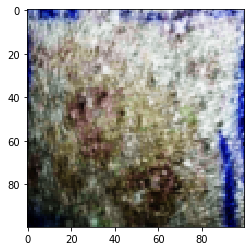

In [16]:
plt.imshow(imgs[:,:,:,7])

# Explore the Data

In [17]:
from skimage.filters import gaussian, prewitt
from skimage.restoration import denoise_wavelet
from skimage.color import rgb2gray

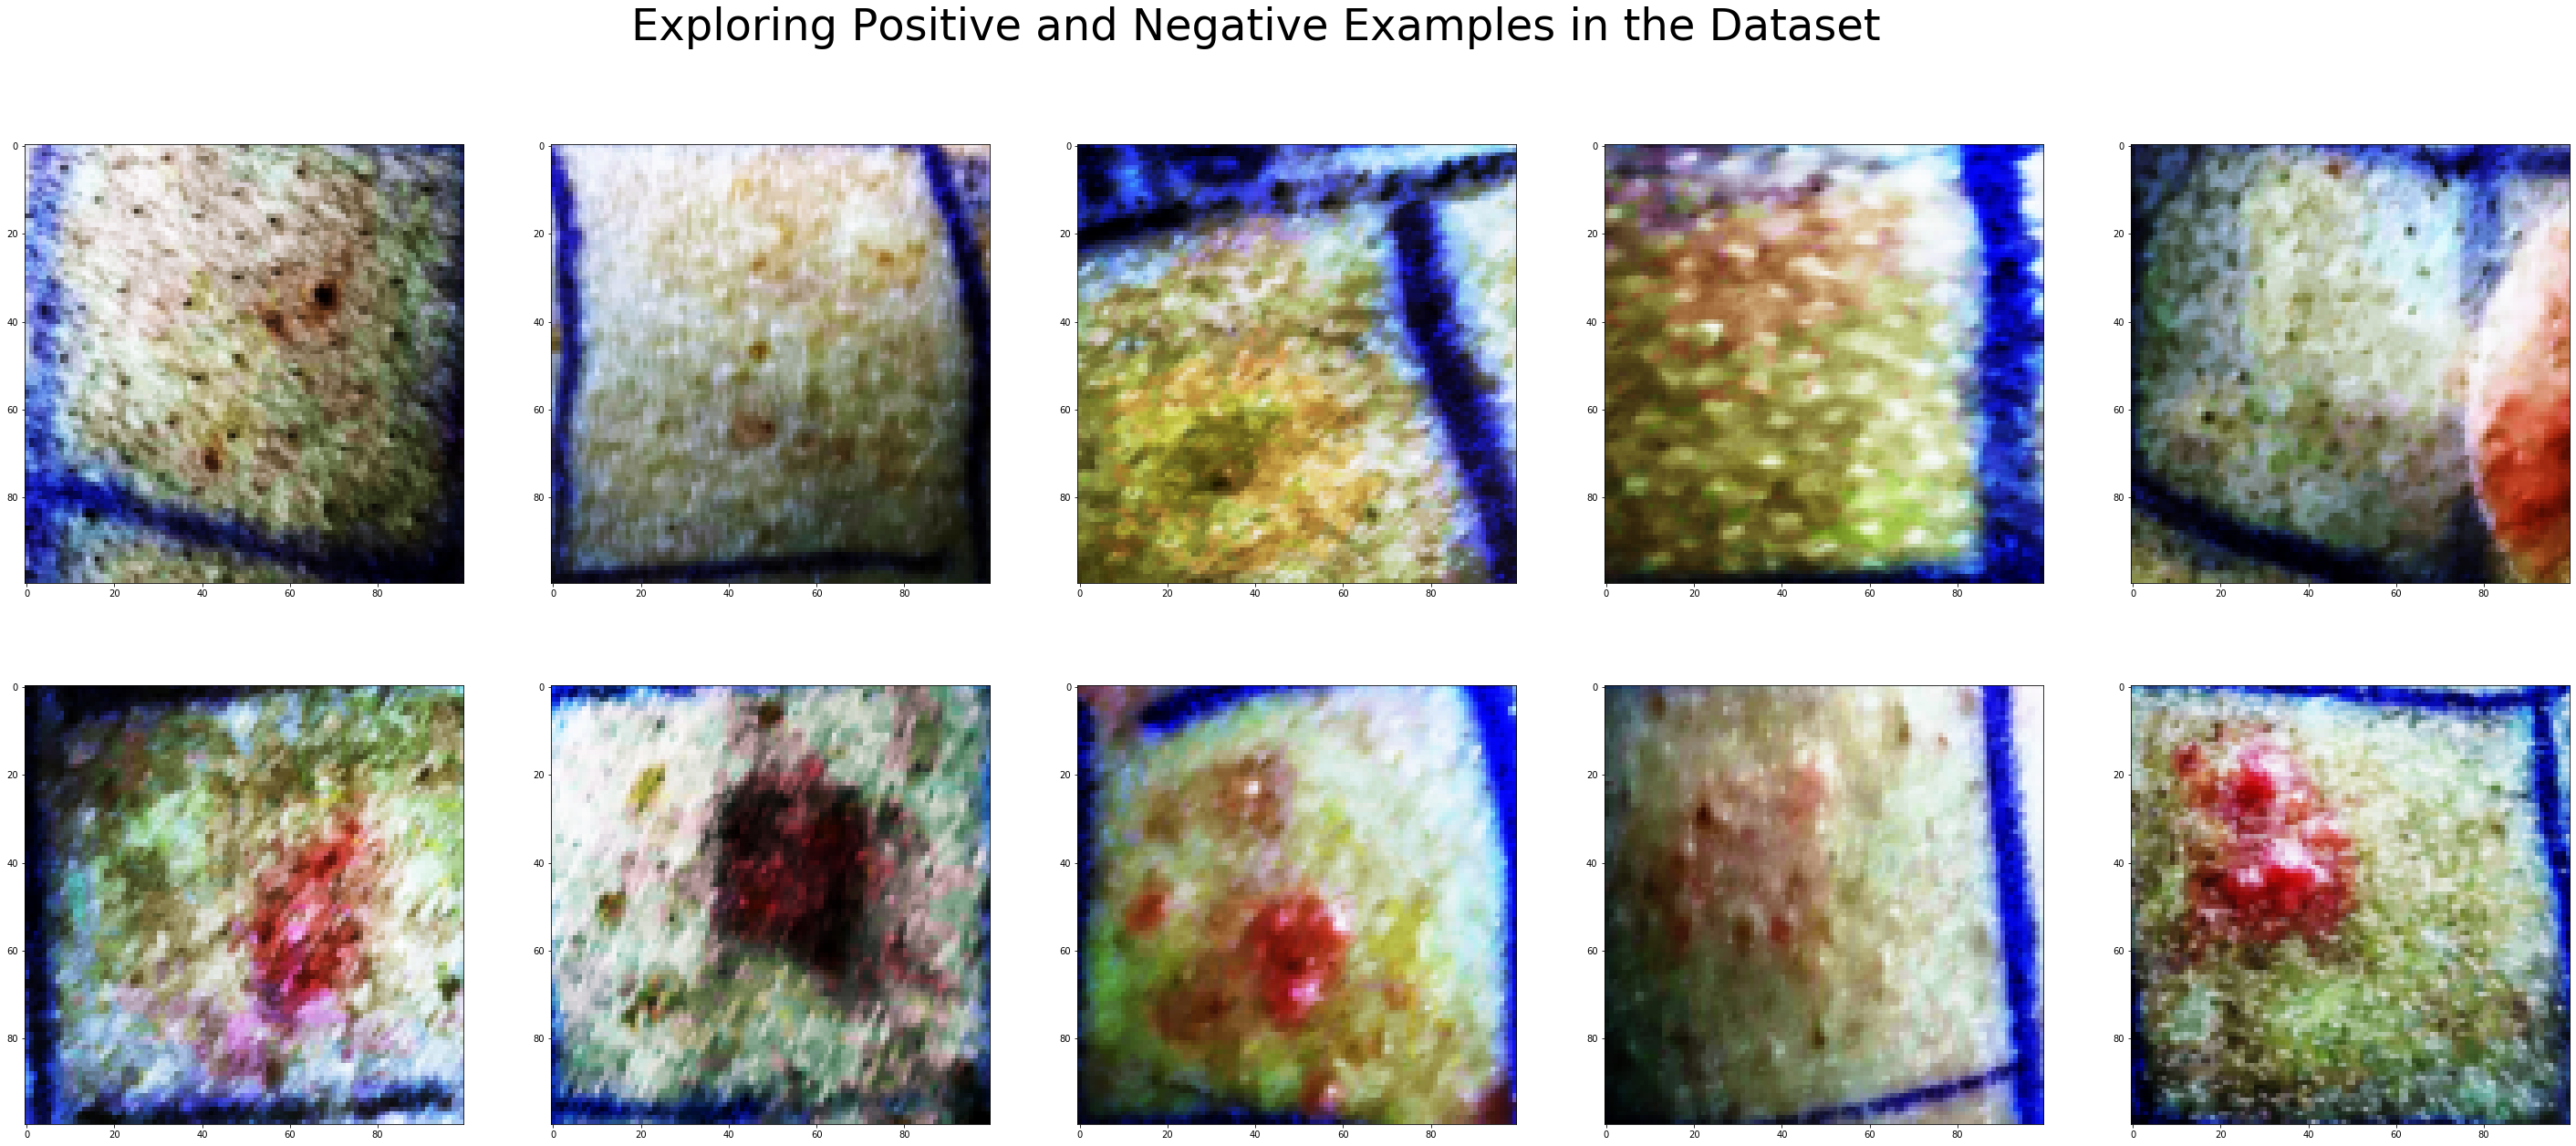

In [18]:
# Let's look at some positive and negative examples 

num_examples = 5
num_classes = 2

negative_indices = np.where(labels == 0)[0]
positive_indices = np.where(labels == 1)[0]

# randomly pick a subset from all of the examples 
negative_example_indices = np.random.choice(negative_indices, num_examples, replace=False)
positive_example_indices = np.random.choice(positive_indices, num_examples, replace=False)

plt.figure(figsize=(50, 20))
plt.suptitle('Exploring Positive and Negative Examples in the Dataset', fontsize=48)

# top row is negative examples 
for i, idx in enumerate(negative_example_indices): 
    plt.subplot(num_classes, num_examples, i+1)    
    plt.imshow(imgs[:,:,:,idx])

# bottom row is positive examples 
for i, idx in enumerate(positive_example_indices): 
    plt.subplot(num_classes, num_examples, i+num_examples+1)    
    plt.imshow(imgs[:,:,:,idx])
    

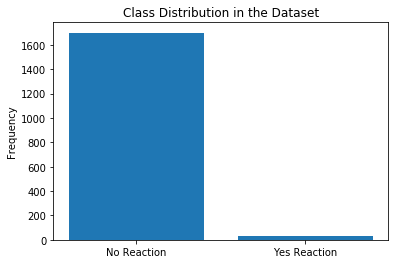

There are 1699 negative examples and 28 positive examples in the data set


In [36]:
# Let's look at the distribution of classes present in the data set 

num_positive = len(positive_indices)
num_negative = len(negative_indices)

classes = ['No Reaction', 'Yes Reaction']
y_pos = np.arange(len(classes))
performance = [num_negative, num_positive]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, classes)
plt.ylabel('Frequency')
plt.title('Class Distribution in the Dataset')

plt.show()

print('There are', int(num_negative), 'negative examples and', int(num_positive), 'positive examples in the data set' )

In [20]:
# let's even out the dataset 
negative_downsample_indices = np.random.choice(negative_indices, len(positive_indices), replace=False)
downsample_indices = np.concatenate((positive_indices, negative_downsample_indices))

imgs = imgs[:,:,:,downsample_indices]
imgs = imgs[:,:]
labels = labels[downsample_indices] 

print(imgs.shape)
print(labels.shape)

(100, 100, 3, 56)
(56,)


# Run Data Augmentations

In [21]:
# Perform data augmentations to increase the size of the dataset 
r, c, ch, num_imgs = imgs.shape

flip_ud = np.zeros((r, c, ch, num_imgs))
flip_lr = np.zeros((r, c, ch, num_imgs))
rot90 = np.zeros((r, c, ch, num_imgs))
rot180 = np.zeros((r, c, ch, num_imgs))
rot270 = np.zeros((r, c, ch, num_imgs))

for i in range(num_imgs):
    
    if i % 100 == 0: # display progress 
        print(i, 'out of', num_imgs, 'images processed')
    original_img = imgs[:,:,:,i] 
    flip_ud[:,:,:,i] = np.flip(original_img, 0) # flip the image up-down
    flip_lr[:,:,:,i] = np.flip(original_img, 1) # flip the image left-right
    rot90[:,:,:,i] = np.rot90(original_img, 1) # rotate the image 90 degrees 
    rot180[:,:,:,i] = np.rot90(original_img, 2) # rotate the image 180 degrees 
    rot270[:,:,:,i] = np.rot90(original_img, 3) # rotate the image 270 degrees 
    
# Put them all together in one matrix 
aug_imgs = np.concatenate((imgs, flip_ud, flip_lr, rot90, rot180, rot270), axis=3)
aug_labels = np.tile(labels, 6) 

# Verify the shape of the resulting matrix 
print(aug_imgs.shape)
print(aug_labels.shape)

0 out of 56 images processed
(100, 100, 3, 336)
(336,)


In [22]:
# save images and labels arrays so we don't have to recompute each time
# np.save('imgs_np_array.npy', aug_imgs)
# np.save('labels_np_array.npy', aug_labels)

# load images and labels arrays 
# aug_imgs = np.load('imgs_np_array.npy')
# aug_labels = np.load('labels_np_array.npy') 

# Start Training Models

In [23]:
print(aug_labels.shape[0])

336


In [24]:
# one how encode the labels for training 
num_labels = aug_labels.shape[0]
one_hot_labels = np.zeros((num_labels,2))

for i in range(num_labels): 
    if aug_labels[i] == 0: 
        one_hot_labels[i,:] = [1, 0]
    else: 
        one_hot_labels[i,:] = [0, 1]

In [25]:
# Split into training, validation, and test sets 
# Note: We have to switch the order of the dimensions of the images so scikit can split it properly 

# Note: This will automatically shuffle the data before splitting it 
# Here we are splitting 70% for training and 20% for testing and 10% for validation 
# We have to use train_test_split twice in order to trick it into splitting off a validation set, too 
imgs_train, imgs_test, labels_train, labels_test = train_test_split(np.rollaxis(aug_imgs, 3), one_hot_labels, test_size=0.30) 
imgs_test, imgs_val, labels_test, labels_val = train_test_split(imgs_test, labels_test, test_size=0.33) 

In [26]:
# We can check that this worked by checking the size of everything 
print(imgs_train.shape, imgs_val.shape, imgs_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

(235, 100, 100, 3) (34, 100, 100, 3) (67, 100, 100, 3)
(235, 2) (34, 2) (67, 2)


In [27]:
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16, MobileNetV2, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [32]:
# since we will be testing many models, let's create a function to train, evaluate, and save statistics about each model 
# my_model: the keras model to train
def train_model(my_model): 
    
    # compile the model
    my_model.compile(loss='mean_squared_error',
        optimizer=optimizers.Adam(),
        metrics=['acc'])
    
    # create keras callbacks 
    es = EarlyStopping(monitor='val_loss', patience=5) 
        
    # train the model
    history = my_model.fit(
        imgs_train,
        labels_train, 
        validation_data=(imgs_val,labels_val), 
        batch_size=32, 
        epochs=25, 
        callbacks=[es] 
    )
    
    # calculate confusion matrix 
    predictions = my_model.predict(imgs_test)
    plot_confusion_matrix(my_model, labels_test.argmax(axis=1), predictions.argmax(axis=1), ['No Reaction', 'Yes Reaction'])
    
    # save training statistics 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    
    plt.figure()

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(my_model.name + '_accuracy.png') 
    
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(my_model.name + '_loss.png') 
    
    # Save the model
    my_model.save(my_model.name + '.h5')

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# This function comes from a scikit example found here: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
def plot_confusion_matrix(model, y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

    np.set_printoptions(precision=2)

In [34]:
# create the base pre-trained model
pretrained_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
custom_model = Model(inputs=pretrained_model.input, outputs=predictions)

# freeze the layers that came in the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

Train on 235 samples, validate on 34 samples
Epoch 1/25
235/235 [==============================] - 11s 48ms/sample - loss: 0.2644 - acc: 0.5319 - val_loss: 0.1725 - val_acc: 0.7353
Epoch 2/25
235/235 [==============================] - 12s 50ms/sample - loss: 0.1678 - acc: 0.7574 - val_loss: 0.1317 - val_acc: 0.8235
Epoch 3/25
235/235 [==============================] - 12s 51ms/sample - loss: 0.1305 - acc: 0.8213 - val_loss: 0.1133 - val_acc: 0.8529
Epoch 4/25
235/235 [==============================] - 12s 53ms/sample - loss: 0.1055 - acc: 0.8638 - val_loss: 0.1290 - val_acc: 0.8235
Epoch 5/25
235/235 [==============================] - 12s 52ms/sample - loss: 0.0930 - acc: 0.8894 - val_loss: 0.0973 - val_acc: 0.8235
Epoch 6/25
235/235 [==============================] - 12s 50ms/sample - loss: 0.0749 - acc: 0.9277 - val_loss: 0.0934 - val_acc: 0.8235
Epoch 7/25
235/235 [==============================] - 12s 49ms/sample - loss: 0.0564 - acc: 0.9745 - val_loss: 0.0974 - val_acc: 0.8824
Epo

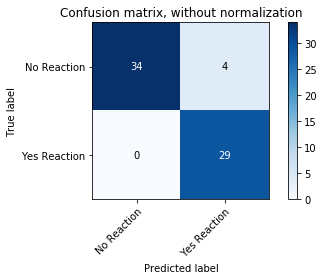

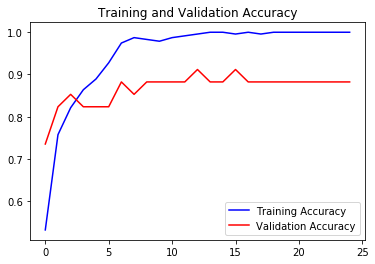

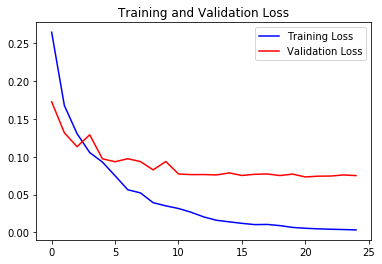

In [35]:
model = train_model(custom_model) 

# IGNORE

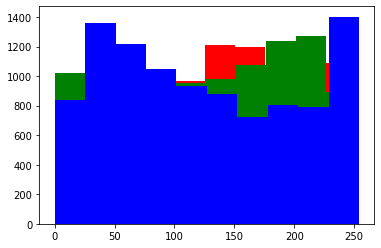

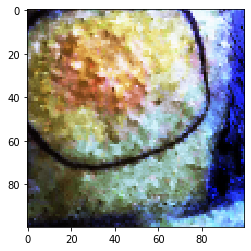

In [304]:
img = preprocess(imgs[:,:,:,9])
plt.close()
plt.hist(img[:,:,0].flatten(), color='r')
plt.hist(img[:,:,1].flatten(), color='g')
plt.hist(img[:,:,2].flatten(), color='b')
plt.show()
plt.imshow(img)
plt.show()